In [1]:
from environment import CarEnv
import numpy as np

import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
state_dim = 50*50
action_dim = 6

### test

In [3]:
# Create an instance of the custom environment
env = CarEnv(10)

# Example of using the environment
obs = env.reset()
score = 0
while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break

print('Score:', score)

Score: 61.384555257212064


In [4]:
env = CarEnv(10,False)
obs = env.reset()


1.585276465364017


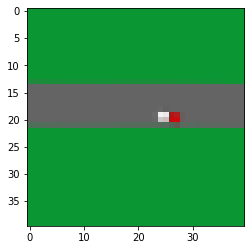

In [5]:
action = env.action_space.sample()
obs, reward, done, _ = env.step(0)

print(reward)
fig = plt.figure
plt.imshow(obs)

### DL models

In [2]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import random
import collections
import itertools
import pandas as pd
import seaborn as sns

c:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class QNetwork(nn.Module):
    def __init__(self, action_dim):
        super(QNetwork, self).__init__()
        
        # Define the layers of the CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.LeakyReLU(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.LeakyReLU(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.LeakyReLU(0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 32)
        self.relu3 = nn.LeakyReLU(0.1)
        self.fc2 = nn.Linear(32, action_dim)
        
    def forward(self, x):
        # Define the forward pass of the CNN
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x



In [5]:
def obs2tensor(obs):
    if not(isinstance(obs[0,0,0], np.uint8)):
        return torch.tensor(obs, dtype=torch.float32).permute(0,3,1,2).to(device)
    else:
        return torch.tensor(obs, dtype=torch.float32).unsqueeze(0).permute(0,3,1,2).to(device)

In [6]:
obstensor = obs2tensor(obs)
model = QNetwork(action_dim).to(device)

model(obstensor)

NameError: name 'obs' is not defined

In [7]:
torch.softmax(torch.Tensor([0.1,1,-0.3,1.1]),dim=0)

tensor([0.1460, 0.3592, 0.0979, 0.3969])

In [8]:
class EpsilonGreedy:
    def __init__(self,
                 epsilon_start: float,
                 epsilon_min: float,
                 epsilon_decay:float,
                 env: gym.Env,
                 q_network: torch.nn.Module):

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: np.ndarray) -> np.int64:

        state = obs2tensor(state)
        if np.max(torch.softmax(self.q_network(state),dim=0).cpu().detach().numpy())<0.3:
            action = self.env.action_space.sample()
        else:
            if np.random.rand() > self.epsilon:
                action = self.q_network(state).argmax(dim=1).item()
                rdm = -1
            else :
                action = self.env.action_space.sample()
                rdm = 1

        return action, rdm
        

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [9]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(self, optimizer: torch.optim.Optimizer, lr_decay: float, last_epoch: int = -1, min_lr: float = 1e-6):

        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self):
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

In [10]:
class ReplayBuffer:
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def add(self, state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size: int):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.array(states), actions, rewards, np.array(next_states), dones

    def __len__(self):
        return len(self.buffer)

In [11]:
def train_dqn2_agent(env: gym.Env,
                     q_network: torch.nn.Module,
                     target_q_network: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     loss_fn,
                     epsilon_greedy: EpsilonGreedy,
                     device: torch.device,
                     lr_scheduler,
                     num_episodes: int,
                     gamma: float,
                     batch_size: int,
                     replay_buffer,
                     target_q_network_sync_period: int,
                     delay):

    iteration = 0
    episode_reward_list = []
    

    for episode_index in tqdm(range(1, num_episodes)):
        state = env.reset()
        episode_reward = 0
        rdm = 10
        target_q_network.load_state_dict(q_network.state_dict())

        for t in itertools.count():

            # Get action, next_state and reward

            if np.abs(rdm) >= delay:
                action,rdm = epsilon_greedy(state)
            elif rdm<0:
                rdm -= 1
            elif rdm >=1:
                rdm += 1

            next_state, reward, done, _ = env.step(action)

            replay_buffer.add(state, action, reward, next_state, done)

            episode_reward += reward
            # Update the q_network weights with a batch of experiences from the buffer

            if len(replay_buffer) > batch_size:
                batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size)

                # Convert to PyTorch tensors
                batch_states_tensor = obs2tensor(batch_states)
                batch_actions_tensor = torch.tensor(batch_actions, dtype=torch.long, device=device)
                batch_rewards_tensor = torch.tensor(batch_rewards, dtype=torch.float32, device=device)
                batch_next_states_tensor = obs2tensor(batch_next_states)
                batch_dones_tensor = torch.tensor(batch_dones, dtype=torch.float32, device=device)

                loss = loss_fn(q_network(batch_states_tensor)[range(batch_actions_tensor.size(0)), batch_actions_tensor], batch_rewards_tensor + gamma * torch.max(target_q_network(batch_next_states_tensor),axis=1).values * (1 - batch_dones_tensor))


                # Optimize the model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                lr_scheduler.step()

            # Update the target q-network

            # Every few training steps (e.g., every 100 steps), the weights of the target network are updated with the weights of the Q-network

            if iteration % target_q_network_sync_period == 0:
                True

            iteration += 1

            if done:
                break

            state = next_state


        episode_reward_list.append(episode_reward)
        epsilon_greedy.decay_epsilon()
        print(episode_reward)
    return episode_reward_list

In [16]:
env = CarEnv(30,False)

NUMBER_OF_TRAININGS = 1
dqn2_trains_result_list = [[], [], []]

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(action_dim).to(device)
    target_q_network = QNetwork(action_dim).to(device)

    optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
    #lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.999, min_lr=0.0001)
    loss_fn = torch.nn.MSELoss()

    epsilon_greedy = EpsilonGreedy(epsilon_start=0.9, epsilon_min=0.001, epsilon_decay=0.9, env=env, q_network=q_network)

    replay_buffer = ReplayBuffer(2000)

    # Train the q-network

    episode_reward_list = train_dqn2_agent(env,
                                           q_network,
                                           target_q_network,
                                           optimizer,
                                           loss_fn,
                                           epsilon_greedy,
                                           device,
                                           lr_scheduler,
                                           num_episodes=1000,
                                           gamma=0.9,
                                           batch_size=128,
                                           replay_buffer=replay_buffer,
                                           target_q_network_sync_period=150,
                                           delay=10)
    dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
    dqn2_trains_result_list[1].extend(episode_reward_list)
    dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")



  0%|          | 0/999 [00:00<?, ?it/s]

72.05774549360662
101.73432901043067
22.79369356964647
108.99810845228164
50.664501235717935
82.87266551316195
83.70482776712501
85.46889719291727
70.83106392870303
130.4273043303845
211.70177444185487
-9.824421127861317
39.09222261002601
190.4270298941761
125.21891779106186
41.21031138266318
33.664218902021325
113.65965162456087
62.118644445355045
205.57066345714472
78.85232703663311
57.11555689368737
113.5526740348244
103.00371086786953
150.52214159967772
113.81757967890877
125.30202545791359
59.887827513230334
157.40373731017365
76.3664273233925
329.19573497354696
134.8813997012644
106.17006924294311
56.660810941101815
48.22751313259169
43.583097947152304
32.08233661247238
80.76818911330648
72.98107326422289
109.15267998855835
38.17857148231996
52.17867697980618
179.59763270851937
332.1741993229259
71.32893446137464
90.41527671675657
26.061949469730102
73.49721894880257
32.58536660139138
68.88889343440819
20.92367175645322
18.07217152004221
99.7852384340279
70.72290078061715
40.1438

In [21]:
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.999, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

epsilon_greedy = EpsilonGreedy(epsilon_start=0.5, epsilon_min=0.001, epsilon_decay=0.9, env=env, q_network=q_network)

replay_buffer = ReplayBuffer(2000)

# Train the q-network

episode_reward_list = train_dqn2_agent(env,
                                        q_network,
                                        target_q_network,
                                        optimizer,
                                        loss_fn,
                                        epsilon_greedy,
                                        device,
                                        lr_scheduler,
                                        num_episodes=1000,
                                        gamma=0.9,
                                        batch_size=128,
                                        replay_buffer=replay_buffer,
                                        target_q_network_sync_period=150,
                                        delay=1)
dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
dqn2_trains_result_list[1].extend(episode_reward_list)
dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")

  0%|          | 0/999 [00:00<?, ?it/s]

399.023761992264
480.97944191522663


KeyboardInterrupt: 

In [23]:
torch.save(q_network, "dqn2_q_network.pth")

In [ ]:
env.close()

In [13]:
q_network = torch.load("verygood2.pth")

In [22]:
env = CarEnv(30,False)
target_q_network = QNetwork(action_dim).to(device)


optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.004, amsgrad=True)
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(optimizer, lr_decay=0.999, min_lr=0.0001)
loss_fn = torch.nn.MSELoss()

epsilon_greedy = EpsilonGreedy(epsilon_start=0.5, epsilon_min=0.001, epsilon_decay=0.9, env=env, q_network=q_network)

replay_buffer = ReplayBuffer(2000)

# Train the q-network

episode_reward_list = train_dqn2_agent(env,
                                        q_network,
                                        target_q_network,
                                        optimizer,
                                        loss_fn,
                                        epsilon_greedy,
                                        device,
                                        lr_scheduler,
                                        num_episodes=300,
                                        gamma=0.95,
                                        batch_size=128,
                                        replay_buffer=replay_buffer,
                                        target_q_network_sync_period=150,
                                        delay=1)
dqn2_trains_result_list[0].extend(range(len(episode_reward_list)))
dqn2_trains_result_list[1].extend(episode_reward_list)
dqn2_trains_result_list[2].extend([train_index for _ in episode_reward_list])

# Save the action-value estimation function

torch.save(q_network, "dqn2_q_network.pth")

  0%|          | 0/299 [00:00<?, ?it/s]

46.108634197642274
39.33997143675706
50.410946289921945
284.2340340651797
31.787963718843972
95.3361123204466
32.24261553750113
33.677592054974646
36.39867645483771
53.60947248088365
44.27979880739913
40.92756233578586
95.90825877680841
93.73699444308579
49.41473086699872
39.98381952739779
43.10675271665249
54.032364883844494
21.41189858610978
140.61397136375862
272.49675879548454
96.50674719158243
352.82127830058675
159.17787765126997
89.39830543392196
45.086660558584924
137.49014227211188
30.967183835064304
350.99009405596996
207.5576425116359
226.713986864218
45.36288354713784
209.32362047525305
209.60130903768356
308.1463720805917
1308.6079540111912
361.02947897152745
532.1934573910825
1023.1842287427471
517.9486126383348
255.69649188868777
201.53179649562887
252.84860791339872
303.4587597364145
49.35205421655333
95.52368827732751
109.75702499861553
66.94806972829369
82.55896370293458
183.74273762499567
175.2199332578963
117.41776686340926
489.1385812253391
85.70291310450474
361.86

KeyboardInterrupt: 

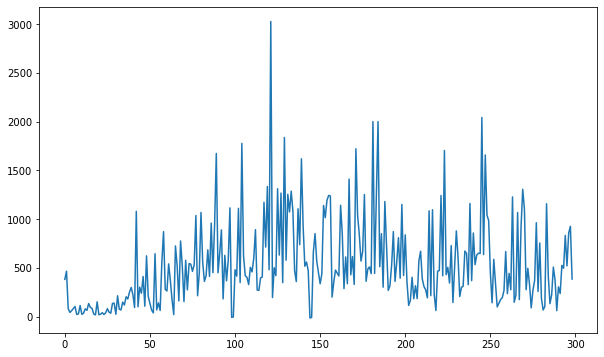

In [23]:
plt.figure(figsize=(10, 6))  # Set the figure size to 10 inches by 6 inches
plt.plot(episode_reward_list)

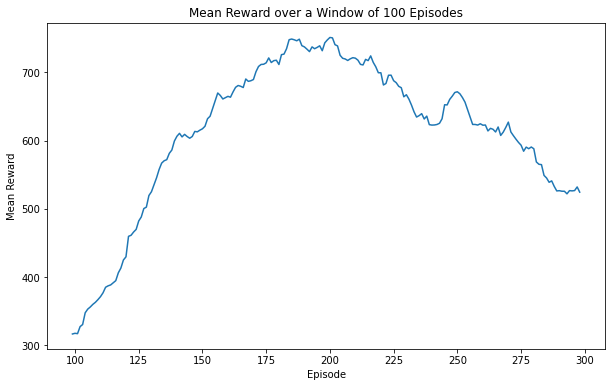

In [24]:
window_size = 100
mean_rewards = pd.Series(episode_reward_list).rolling(window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title(f'Mean Reward over a Window of {window_size} Episodes')
plt.show()


In [15]:
import pygame as pg

# Create an instance of the custom environment
env = CarEnv(60,evaluation=True)

clock = pg.time.Clock()

# Example of using the environment
obs = env.reset()
score = 0

while True:
    clock.tick(30)
    obstensor = obs2tensor(obs)
    action = q_network(obstensor).argmax(dim=1)
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break
print(score)

KeyboardInterrupt: 

In [24]:
torch.save(q_network, "verygood2.pth")